In [4]:
''' 
Development Juptyer Notebooks for The Benchmark Calculation Overtime . 
''' 

from abc import abstractmethod, ABC 
import pandas as pd 
from typing import Iterable, List, Optional
from datetime import datetime
import numpy as np

In [137]:
'''  
pulling cleaned data into the notebook 
'''
df = pd.read_csv("bloomberg_data_cleaned.csv")

#set date to datetime object 
df["date"] = pd.to_datetime(df["date"])
df.set_index(["date","ticker"],inplace= True)
pd.set_option('display.float_format', '{:,.4f}'.format)
df.head()

market_cap  ...  close_price
date       ticker                 ...             
2022-01-03 A         47,257.0847  ...     156.4800
           AA        11,293.5460  ...      60.3600
           AAL       12,140.8973  ...      18.7500
           AAON       4,106.6876  ...      52.2200
           AAPL   2,986,128.3180  ...     182.0100

[5 rows x 7 columns]

In [ ]:



class Benchmark2:
    """_summary_
    """
    def __init__(self, data: pd.DataFrame, benchmark_start_val: float): 
        self.data: pd.DataFrame = data
        self.cur_constituents: List[str] #this is all of current member of the index. 
        self.dates: List[datetime]= self.data.index.get_level_values("date").unique().to_list()
        self.cur_date: datetime  = self.dates[0]
        self._i: int = 0 
        self.price_history = pd.Series(data = 0.0, index = self.dates)
        self.benchmark_divisor: float = 1
        self.quarterly_recon_dates: List[datetime] = []
        self._get_quarterly_reconst_dates() 
        self.random_constitution()
        self._calc_benchmark_divisor(benchmark_start_val) 
    
    #=========================================================
    #          Benchmark Constitution Methods
    #========================================================


    def next_benchmark_price(self) -> float: 
        if self.is_reconstitution_date():
            # reconsitute the benchmark. 
            None 
        next_benchmark = self._calc_numerator() / self.benchmark_divisor
        self.price_history.loc[self.cur_date] = next_benchmark #type: ignore 
        self.next_date() 
        return next_benchmark
    
    def _calc_numerator(self)-> float: 
        numerator: float = 0
        for ticker in self.cur_constituents: 
            key = (self.cur_date,ticker)
            cap_val  = self.data.loc[key]["market_cap"] # type: ignore 
            if np.isnan(cap_val): 
                cap_val = 0.00 
            numerator +=  cap_val 
        return numerator


    def _calc_benchmark_divisor(self, start_val: float) -> None: 
        # numerator / start_vale = divisor. 
        self.benchmark_divisor = self.next_benchmark_price() / start_val
    
    #=========================================================
    #          Benchmark Constitution Methods
    #========================================================

    def random_constitution(self):
        tickers = self.data.index.get_level_values("ticker").unique()
        mask = [] 
        rnd_selection =  np.random.randint(0,tickers.__len__(),282)
        for i, ticker in enumerate(range(tickers.__len__())): 
            if i in rnd_selection: 
                mask += [True]
            else: 
                mask += [False]
        self.cur_constituents = tickers[mask].to_list()

    #========================================================
    #           Date Handling Methods: 
    #========================================================
    
    def _get_quarterly_reconst_dates(self) -> None: 
        """
        Last trading of the months January, April, July, October
        """
        s_dates: pd.Series = pd.Series(self.dates)
        for year in range(self.dates[0].year, self.dates[-1].year + 1):
            for month in [1,4,7,10]:
                year_month_mask = (s_dates.dt.year == year) &  (s_dates.dt.month == month) #type: ignore 
                self.quarterly_recon_dates += [s_dates[year_month_mask].iloc[-1]]

    def _get_annual_reconstitution_dates(self) -> List[datetime]:
        """Maria: method"""
        dates = self.data.index.get_level_values("date").unique()
        recon = []
        years = pd.DatetimeIndex(dates).year.unique()
        for year in years:
            june = [d for d in dates if d.year == year and d.month == 6]
            if not june:
                continue
            fridays = [d for d in june if pd.Timestamp(d).weekday() == 4] # Monday=0 ... Friday=4
            if not fridays:
                continue

            fridays = sorted(fridays)
            if len(fridays) >= 4:
                recon.append(fridays[3]) # 4th Friday (0-indexed)
            else:
                recon.append(fridays[-1]) # fallback: last Friday available
        return recon


    def is_reconstitution_date(self) -> bool:  
        out = False
        annual_recon_dates = self._get_annual_reconstitution_dates()
        if self.cur_date in annual_recon_dates: 
            return True
        if self.cur_date in self.quarterly_recon_dates: 
            return True 
        return False 
              

    def next_date(self) -> Optional[datetime]:
        if self._i < self.dates.__len__(): 
            self.cur_date = self.dates[self._i]
            self._i += 1 
            return self.cur_date
        else:
            return None 
        

In [166]:
bench = Benchmark(df,100)
iter = 0
while bench.cur_date is not None: 
    iter += 1 
    if iter > 100000: break
    #print(bench.cur_date)
    bench.next_benchmark_price()

bench.price_history


KeyboardInterrupt: 

In [98]:
bench = Benchmark(df)
bench._get_quarterly_reconst_dates_2()
bench.quarterly_recon_dates

d = datetime.strptime('2025-10-31 00:00:00', '%Y-%m-%d %H:%M:%S')
d in bench.quarterly_recon_dates

True

In [167]:
bench.price_history


2022-01-03   100.0000
2022-01-04    99.7669
2022-01-05    97.7660
2022-01-06    97.6922
2022-01-07    97.3352
               ...   
2025-12-24   139.9594
2025-12-26   139.7869
2025-12-29   139.2592
2025-12-30   139.2605
2025-12-31   138.0941
Length: 1003, dtype: float64

In [ ]:
bench = Benchmark(df,1000000)


In [116]:
tickers = df.index.get_level_values("ticker").unique()
mask = [] 
rnd_selection =  np.random.randint(0,tickers.__len__(),282)
for i, ticker in enumerate(range(tickers.__len__())): 
    if i in rnd_selection: 
        mask += [True]
    else: 
        mask += [False]
mask
tickers[mask]

Index(['AAON', 'AAPL', 'ACI', 'ADT', 'AES', 'AFL', 'AGCO', 'AGO', 'AIZ', 'AJG',
       ...
       'WLK', 'WMB', 'WMS', 'WMT', 'WU', 'WYNN', 'XP', 'XRAY', 'Z', 'ZS'],
      dtype='object', name='ticker', length=250)

In [119]:
rnd_selection.__len__()
mask.__len__()

1010

In [147]:
bench = Benchmark(df,1000000)
len(bench.cur_constituents)
bench.benchmark_divisor
bench._calc_numerator()
bench.next_date()

Timestamp('2022-01-04 00:00:00')

In [148]:
bench.next_benchmark_price()
bench.next_benchmark_price()
bench.next_benchmark_price()
bench.next_benchmark_price()

np.float64(979452.2028593788)

In [157]:
bench.price_history
price_history = pd.Series(
    data = 0.0,
    index = bench.dates 
)
d = datetime.strptime('2025-10-31 00:00:00', '%Y-%m-%d %H:%M:%S')
print(d)
price_history.loc[d] = 4 
price_history.loc[d]

2025-10-31 00:00:00


np.float64(4.0)

In [ ]:
'''
realistically the bechmark itself should be place into a dataframe of the form 
index = Dates | Benchmark_Price | Divisor | Market Cap 

''' 
'''
==========================================
        Data Availability Dataframe: 
==========================================
other thoughts on data availability. Overall what we have is 

'''


data_stats_df = pd.DataFrame(
    columns = ["has_market_cap_data","has_all_data"] 

)




In [ ]:
df.loc[d,:]

In [123]:
""" 
==========================================================
         Index Composition and Reconstitution Class
==========================================================
data. is our base dataframe 
"""
from dataframehelper import DataframeHelper


class IndexComposer:
    '''     
    Based on maria, filtering functions. Index Composer will work in conjuction with 
    the benchmark class. It's primary purpose is to take in a single day and
    and stock data universe as inputs and spit out subset of tickers that will constitute 
    the midcap growth index.  
    ''' 
    def __init__(self,data: pd.DataFrame, day: datetime ) -> None: 
        self.data: pd.DataFrame = data
        self.df_helper = DataframeHelper(data) 
        self.day: datetime = day
        self.day_slice: pd.DataFrame = self.df_helper.slice_by_day(day)
        self._midcap_800: pd.DataFrame = self.get_midcap_800()
        self.growth_subset: pd.Series = self.growth_subset_filter_v1() #type: ignore 
        self.growth_subset_weights = self.get_weights() 
        self.growth_subset_shares = self.get_share_count()  

    def get_midcap_800(self) -> pd.DataFrame: 
        ''' This needs to be date based: we only want to drop NA values 
            for a given day
        '''
        # get all of the data for that day 
        df = self.day_slice 
        # filter only for stocks that are not NA. 
        df = df.dropna(subset = ["market_cap"]).copy()
        #sort from largest to smallest 
        df.sort_values(by = "market_cap", ascending= False, inplace= True)
        # filter out the largest 200 stocks 
        df = df.iloc[199:,]
        return df


    def compute_growth_probability(self, k=5.0) -> pd.Series:
        '''
        Computing Growth Probability

        Since right now we only have P/B data, we can approximate growth
        classification using inverse price-to-book (B/P) mapped into a 
        smooth probability via a logistic function.
        '''
        midcap = self._midcap_800
        pb = midcap["price_to_book"].astype(float)

        #convert P/B to B/P since Russell uses B/P
        bp = np.where((pb > 0 ) & np.isfinite(pb), 1.0 / pb, np.nan)
        bp = pd.Series(bp, index=midcap.index)
        bp = bp.fillna(bp.median()) # to fill empty values (for later computation)

        z = (bp -bp.mean()) / (bp.std(ddof=0) + 1e-12) # z-score for standardization
        z_growth = -z # low B/P -> growth, so now high z_growth -> more growthlike

        #normalizing
        #very neg z_growth -> 0 (value), very pos z_growth -> 1 (growth)
        p = 1 / (1 + np.exp(-k * z_growth)) 

        return pd.Series(p, index=midcap.index, name="p_growth")
    
    def growth_subset_filter_v1(self) -> pd.Series:
        growth_subset_mask = self.compute_growth_probability() > .85
        growth_subset = self._midcap_800.loc[growth_subset_mask]
        return pd.Series(growth_subset.index.get_level_values("ticker"))
    
    def get_weights(self) -> pd.Series: 
        df = self.day_slice
        df = df.reset_index() 
        df = df.set_index("ticker")
        growth_subset = self.growth_subset
        df = df.loc[growth_subset]
        total_cap = df["market_cap"].sum() 
        return df["market_cap"] / total_cap
    
    def get_share_count(self) -> pd.Series: 
        df = self.day_slice
        df = df.reset_index() 
        df = df.set_index("ticker")
        growth_subset = self.growth_subset
        df = df.loc[growth_subset]
        return df["market_cap"] / df["close_price"]

In [135]:
IC = IndexComposer(df, datetime(2022,1,3)) 
IC._midcap_800
IC.growth_subset
IC.get_weights()
IC.get_share_count()
IC.growth_subset_weights
IC.growth_subset_shares
IC.growth_subset


0      APTV
1      CTAS
2      TROW
3      ANET
4      DELL
       ... 
306    WFRD
307    VNOM
308     ELF
309     DJT
310    ASTS
Name: ticker, Length: 311, dtype: object

In [181]:
class Benchmark:
    """_summary_
    """
    def __init__(self, data: pd.DataFrame, benchmark_start_val: float): 
        self.data: pd.DataFrame = data
        self.cur_constituents: pd.Series #this is all of current member of the index. 
        self.dates: pd.Series = pd.Series(self.data.index.get_level_values("date").unique())
        self.cur_date: datetime  = self.dates[0]
        self._i: int = 0 
        self.bechmark_timeseries = pd.Series(data = 0.0, index = self.dates)
        self.benchmark_divisor: float = 1
        self.quarterly_recon_dates: List[datetime] = []
        self._get_quarterly_reconst_dates()
        self.annual_recon_dates = self._get_annual_reconstitution_dates() 
        self.benchmark_makeup_dict: dict = {}
        self.cur_divisor: float = 0.0
        self.DataHelper = DataframeHelper(self.data)

    #=========================================================
    #          Benchmark Constitution Methods
    #========================================================
    def calculate_benchmark(self): 
        # set the benchmark constitution on the first day of the calculation
        composer = IndexComposer(self.data, self.cur_date)
        self.cur_constituents = composer.growth_subset
        self.benchmark_makeup_dict[self.cur_date] = composer.growth_subset
        
        # calculate benchmark for the first day
        print(f"calculating benchmark for the first day {self.cur_date}")
        day_df = composer.day_slice
        day_df = day_df.reset_index() 
        day_df.set_index("ticker",inplace= True)
        day_df = day_df.loc[composer.growth_subset]

        # add columns to day df that we need for calculating the cap adjusted benchmark 
        day_df["weights"] = composer.growth_subset_weights
        day_df["shares"] = composer.growth_subset_shares
        day_df["weight_adjusted_cap"] = day_df["weights"] * day_df["shares"] * day_df["close_price"]
        
        cap_weighted_benchmark_numerator = day_df["weight_adjusted_cap"].sum() 
        self.cur_divisor = cap_weighted_benchmark_numerator / 1839.00  # hardcoded for now #todo will updated soon 
        first_benchmark_price = cap_weighted_benchmark_numerator / self.cur_divisor
        self.bechmark_timeseries.loc[self.cur_date] = first_benchmark_price #type: ignore

        while self.next_date() is not None:
            if self.cur_date in self.annual_recon_dates:
                print(f"{self.cur_date} is an reconsitution date" )
                composer = IndexComposer(self.data,self.cur_date)
                self.benchmark_makeup_dict[self.cur_date] = composer.growth_subset
                # when there is recomposition we'll need to rescale the divisor, we'll take the new bench mark
                # constitution, weights and share counts and calculate what divisor makes its such that the 
                # new constitution equals the previous constitutions benchmark value
                prev_date = self.dates[self._i - 2]

                # add columns to day df that we need for calculating the cap adjusted benchmark 
                prev_day_df = self.DataHelper.slice_by_day(prev_date)
                prev_day_df = prev_day_df.reset_index() 
                prev_day_df.set_index("ticker",inplace= True)
                prev_day_df = prev_day_df.loc[composer.growth_subset]
                prev_day_df["weights"] = composer.growth_subset_weights
                prev_day_df["shares"] = composer.growth_subset_shares
                prev_day_df["weight_adjusted_cap"] = prev_day_df["weights"] * prev_day_df["shares"] * prev_day_df["close_price"]
                cap_weighted_benchmark_numerator = prev_day_df["weight_adjusted_cap"].sum()

                self.cur_divisor =  cap_weighted_benchmark_numerator / self.bechmark_timeseries.loc[prev_date]
                print(f" cur_divisor is {self.cur_divisor},  self.bechmark_timeseries.loc[prev_date])")
            
            # add columns to day df that we need for calculating the cap adjusted benchmark 
            day_df = self.DataHelper.slice_by_day(self.cur_date)
            day_df.reset_index(inplace= True)
            day_df.set_index("ticker",inplace= True)
            day_df = day_df.loc[composer.growth_subset]
            day_df["weights"] = composer.growth_subset_weights
            day_df["shares"] = composer.growth_subset_shares
            day_df["weight_adjusted_cap"] = day_df["weights"] * day_df["shares"] * day_df["close_price"]
            cap_weighted_benchmark_numerator = day_df["weight_adjusted_cap"].sum() 
            benchmark_price = cap_weighted_benchmark_numerator / self.cur_divisor
            self.bechmark_timeseries.loc[self.cur_date] = benchmark_price #type: ignore

    #========================================================
    #           Date Handling Methods: 
    #========================================================
    
    def _get_quarterly_reconst_dates(self) -> None: 
        """
        Last trading of the months January, April, July, October
        """
        s_dates = self.dates
        l_dates: list[datetime] = self.dates.to_list() 
        for year in range(l_dates[0].year, l_dates[-1].year + 1):
            for month in [1,4,7,10]:
                year_month_mask = (s_dates.dt.year == year) &  (s_dates.dt.month == month) #type: ignore 
                self.quarterly_recon_dates += [s_dates[year_month_mask].iloc[-1]]

    def _get_annual_reconstitution_dates(self) -> List[datetime]:
        """Maria: method"""
        dates = self.data.index.get_level_values("date").unique()
        recon = []
        years = pd.DatetimeIndex(dates).year.unique()
        for year in years:
            june = [d for d in dates if d.year == year and d.month == 6]
            if not june:
                continue
            fridays = [d for d in june if pd.Timestamp(d).weekday() == 4] # Monday=0 ... Friday=4
            if not fridays:
                continue

            fridays = sorted(fridays)
            if len(fridays) >= 4:
                recon.append(fridays[3]) # 4th Friday (0-indexed)
            else:
                recon.append(fridays[-1]) # fallback: last Friday available
        return recon


    def is_reconstitution_date(self) -> bool:  
        out = False
        annual_recon_dates = self._get_annual_reconstitution_dates()
        if self.cur_date in annual_recon_dates: 
            return True
        if self.cur_date in self.quarterly_recon_dates: 
            return True 
        return False 

    def set_cur_date(self, day: datetime):
        if day not in self.dates.to_list(): 
            raise ValueError("Invalid Day Selected") 
        self.cur_date = day
        self._i = self.dates.to_list().index(day)
        

    def next_date(self) -> Optional[datetime]:
        if self._i < self.dates.__len__(): 
            self.cur_date = self.dates[self._i]
            self._i += 1 
            return self.cur_date
        else:
            return None 
        

In [182]:
'''  
pulling cleaned data into the notebook 
'''
df = pd.read_csv("bloomberg_data_cleaned.csv")

#set date to datetime object 
df["date"] = pd.to_datetime(df["date"])
df.set_index(["date","ticker"],inplace= True)
pd.set_option('display.float_format', '{:,.4f}'.format)
df.head()

bench = Benchmark(df,1000)
bench.dates[0]

Timestamp('2022-01-03 00:00:00')

In [183]:
bench.calculate_benchmark()

calculating benchmark for the first day 2022-01-03 00:00:00
2022-06-24 00:00:00 is an reconsitution date
 cur_divisor is 14.364035185622791,  self.bechmark_timeseries.loc[prev_date])
2023-06-23 00:00:00 is an reconsitution date
 cur_divisor is 13.831382310280812,  self.bechmark_timeseries.loc[prev_date])
2024-06-28 00:00:00 is an reconsitution date
 cur_divisor is 14.079188892396626,  self.bechmark_timeseries.loc[prev_date])
2025-06-27 00:00:00 is an reconsitution date
 cur_divisor is 13.189862018360119,  self.bechmark_timeseries.loc[prev_date])


In [ ]:
bench.bechmark_timeseries
bench.benchmark_makeup_dict

{Timestamp('2022-01-03 00:00:00'): 0      APTV
 1      CTAS
 2      TROW
 3      ANET
 4      DELL
        ... 
 306    WFRD
 307    VNOM
 308     ELF
 309     DJT
 310    ASTS
 Name: ticker, Length: 311, dtype: object,
 Timestamp('2022-06-24 00:00:00'): 0       CMG
 1        ZM
 2        EA
 3         A
 4       DVN
        ... 
 303    FRHC
 304    VNOM
 305    WFRD
 306     ELF
 307    ASTS
 Name: ticker, Length: 308, dtype: object,
 Timestamp('2023-06-23 00:00:00'): 0       IQV
 1      PAYX
 2       COR
 3        ON
 4        DG
        ... 
 304    CORT
 305    VKTX
 306    SMMT
 307    VNOM
 308    ASTS
 Name: ticker, Length: 309, dtype: object,
 Timestamp('2024-06-28 00:00:00'): 0      FTNT
 1      TEAM
 2      MRNA
 3      SNOW
 4      DXCM
        ... 
 318     TDC
 319    YETI
 320    IRDM
 321    ASTS
 322    RKLB
 Name: ticker, Length: 323, dtype: object,
 Timestamp('2025-06-27 00:00:00'): 0       LNG
 1      TEAM
 2       SPG
 3      PAYX
 4      NDAQ
        ... 
 339    

In [185]:
bench.bechmark_timeseries

date
2022-01-03   1,839.0000
2022-01-04   1,823.1135
2022-01-05   1,763.2321
2022-01-06   1,760.7534
2022-01-07   1,737.4821
                ...    
2025-12-24   2,121.5925
2025-12-26   2,121.9473
2025-12-29   2,113.5868
2025-12-30   2,106.8514
2025-12-31   2,085.0284
Length: 1003, dtype: float64

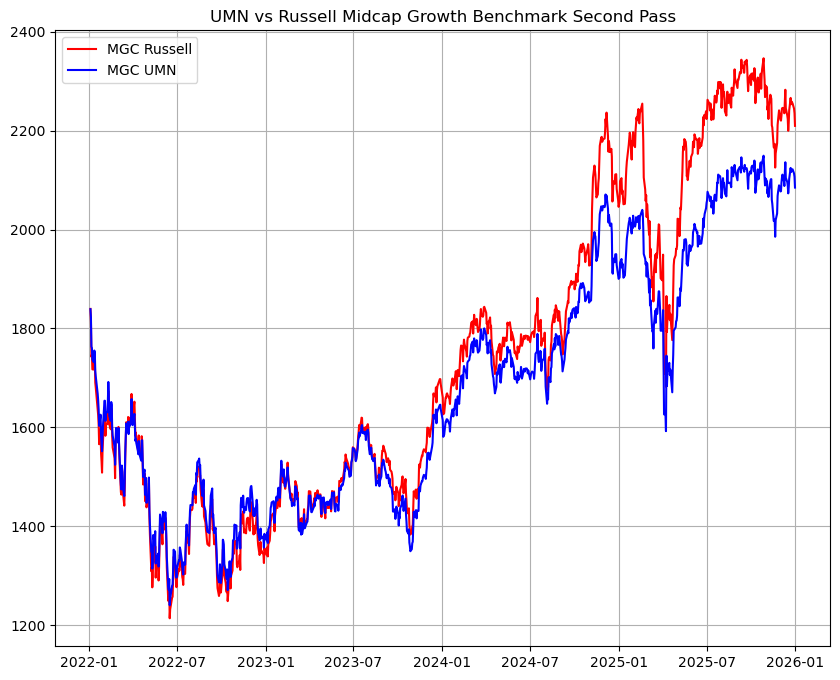

In [187]:
from matplotlib import pyplot as plt
from matplotlib.axes._axes import Axes

import pandas as pd

index_df_real = pd.read_csv("RMCCG_Value.csv")
index_df_real["Date"] = pd.to_datetime(index_df_real["Date"])
index_df_real.set_index("Date",inplace = True)




x_data = bench.bechmark_timeseries.index
y_data_real: pd.Series = index_df_real["Close"].iloc[505:,] #type:  ignore 
y_data_umn = bench.bechmark_timeseries
y_data_real_clean = y_data_real.str.replace(',', '').astype(float)
y_data_real_clean_clean = pd.to_numeric(y_data_real_clean, errors='coerce').astype(np.float64)

plt.figure(figsize = (10,8))

plt.plot(x_data, y_data_real_clean_clean, label = "MGC Russell", color = "red")
plt.plot(x_data, y_data_umn, label = "MGC UMN", color = "blue")
plt.grid(True)
plt.legend()
plt.title("UMN vs Russell Midcap Growth Benchmark Second Pass")
plt.show()

